<a href="https://colab.research.google.com/github/FutureAndroidLearn/coursera-kaggle-project/blob/master/03_ModelingRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Time series

Here, we are gonna to build our initial models, keeping in mind the concept of data stationarity. The workflow that we are going to follow is:

1. Consolidate all data into total sales monthly
2. Check if data is stationary
3. Set look-back period based on autocorrelation and partial autocorrelation
4. Built dataframes
5. Built the models

This notebook are based on the ideas presented at:

1. https://towardsdatascience.com/5-machine-learning-techniques-for-sales-forecasting-598e4984b109
2. https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
3. https://towardsdatascience.com/predicting-sales-611cb5a252de

In [0]:
# Import data from csv files
sales_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/sales_train.zip')
shops_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/shops.csv')
categories_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/item_categories.csv')
items_data = pd.read_csv('/content/drive/My Drive/coursera-kaggle-project/items.csv')

In [4]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
# Initially we are going to group data on 'date_block_num' to check if data is stationary or not.
data_day = sales_data.copy()
data_month = data_day.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
data_month.head()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


In [0]:
# We need to calculate the mean of sales on a yearly basis, so we add a new column for 'year'

def set_year(month):
    if month <= 11:
        return 0
    elif month <= 23:
        return 1
    else:
        return 2
    
year = [set_year(x) for x in data_month.date_block_num]
data_month['year'] = year
data_month.head()

,date_block_num,item_cnt_day,year
0,0,131479.0,0
1,1,128090.0,0
2,2,147142.0,0
3,3,107190.0,0
4,4,106970.0,0


In [0]:
# We calculate the mean of sales for every year and create a new column 'mean'
# Also rename the column 'item_cnt_day'

mean_year = data_month.groupby('year')['item_cnt_day'].mean()
data_month['mean']= data_month['year'].map(mean_year)
data_month.rename({'item_cnt_day':'sales_month'}, axis = 1, inplace =True)
data_month.head()

,date_block_num,sales_month,year,mean
0,0,131479.0,0,130227.75
1,1,128090.0,0,130227.75
2,2,147142.0,0,130227.75
3,3,107190.0,0,130227.75
4,4,106970.0,0,130227.75


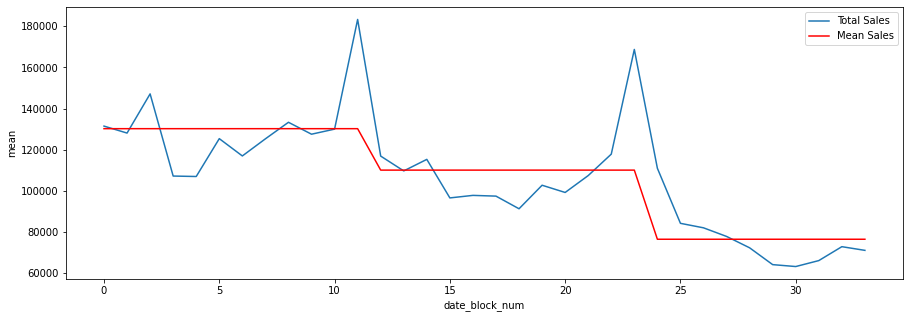

In [0]:
# We plot sales by month and mean by year

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot('date_block_num', 'sales_month', data=data_month, label='Total Sales')
sns.lineplot('date_block_num', 'mean', data=data_month, color='red', label='Mean Sales')      

In [0]:
def get_diff(data):
    data['sales_diff'] = data.sales_month.diff()
    data=data.dropna()
    return data

stationary_df = get_diff(data_month)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


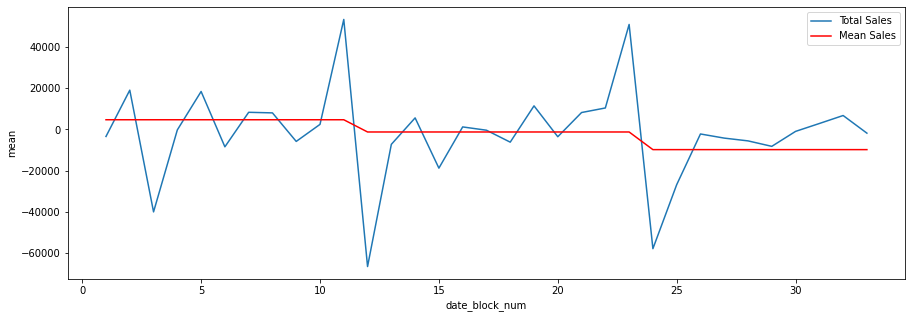

In [0]:
mean_year = stationary_df.groupby('year')['sales_diff'].mean()
stationary_df['mean']= stationary_df['year'].map(mean_year)
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot('date_block_num', 'sales_diff', data=stationary_df, label='Total Sales')
sns.lineplot('date_block_num', 'mean', data=stationary_df, color='red', label='Mean Sales')  

So far we know the data is not stationary and we need to aply a diff transformation in order to remove the trends observed in the data. But the diff transformation, should be applied in different way from that apllied before, cause we can't sum up all items in single month

In [0]:
# We organize a new data frame according to the project requirements

data = sales_data.groupby(['item_id', 'shop_id', 'date_block_num']).sum().reset_index()
data.drop('item_price', axis = 1, inplace = True)
data = data.sort_values(['date_block_num','shop_id','item_id'])
data.rename({'item_cnt_day':'sales_month'}, axis= 1 , inplace = True)
print(data.shape)
data.head()

(1609124, 4)


,item_id,shop_id,date_block_num,sales_month
1148,32,0,0,6.0
1933,33,0,0,3.0
2600,35,0,0,1.0
3143,43,0,0,1.0
3665,51,0,0,2.0


In [0]:
data['last_month_sales'] = data.groupby(['item_id', 'shop_id'])['sales_month'].shift()

In [0]:
data['last_month_diff'] = data.groupby(['item_id', 'shop_id'])['last_month_sales'].diff()

In [0]:
data = data.dropna()

In [0]:
data.head()

,item_id,shop_id,date_block_num,sales_month,last_month_sales,last_month_diff
12679,482,2,2,1.0,1.0,0.0
13533,484,2,2,2.0,4.0,2.0
19294,785,2,2,4.0,1.0,0.0
19931,791,2,2,2.0,1.0,-1.0
33636,1007,2,2,2.0,1.0,-2.0


In [0]:
data[(data['item_id'] == 5822)&(data['shop_id'] == 21)]

,item_id,shop_id,date_block_num,sales_month,last_month_sales,last_month_diff
468680,5822,21,3,2.0,7.0,5.0
468681,5822,21,4,6.0,2.0,-5.0
468682,5822,21,5,3.0,6.0,4.0
468683,5822,21,6,3.0,3.0,-3.0
468684,5822,21,7,5.0,3.0,0.0
468685,5822,21,8,3.0,5.0,2.0
468686,5822,21,9,6.0,3.0,-2.0
468687,5822,21,10,5.0,6.0,3.0
468688,5822,21,11,7.0,5.0,-1.0
468689,5822,21,12,11.0,7.0,2.0


In [0]:
# Now, we split data en train and test
# Last 8 months will be our test set, the rest data will be used to train our model. 
# That give us a 80/20 proportion

val_set = data[data['date_block_num'] > 25]
train_set = data[data['date_block_num'] <= 25]
print(len(val_set)/len(data))
print(len(train_set)/len(data))

0.2077394444340374
0.7922605555659625


In [0]:
xtr, xts = train_set.drop(['sales_month'], axis = 1), val_set.drop(['sales_month'], axis = 1)
ytr, yts = train_set['sales_month'].values, val_set['sales_month'].values

In [0]:
# Create regression object
rf = RandomForestRegressor(n_estimators = 100, random_state=0)

# Train the model on training data
rf.fit(xtr, ytr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
p = rf.predict(xts)

In [0]:
rmse = np.sqrt(mean_squared_error(yts, p))
rmse

9.220996577743234

In [0]:
df = pd.DataFrame (columns = ['Real','Predicted'])
df['Real'] = yts
df['Predicted'] = p

In [0]:
df.describe()

,Real,Predicted
count,188525.000000,188525.000000
mean,2.051441,2.028251
std,11.005639,5.643854
min,-2.000000,-0.340000
25%,1.000000,1.120000
50%,1.000000,1.410000
75%,2.000000,1.930000
max,2253.000000,460.880000


In [0]:
# We organize a new data frame according to the project requirements with clip function

data_cl = sales_data.groupby(['item_id', 'shop_id', 'date_block_num']).sum().reset_index()
data_cl.drop('item_price', axis = 1, inplace = True)
data_cl = data_cl.sort_values(['date_block_num','shop_id','item_id'])
data_cl.rename({'item_cnt_day':'sales_month'}, axis= 1 , inplace = True)
print(data_cl.shape)
data_cl.sales_month = data_cl.sales_month.clip(0,20)
data_cl.head()

(1609124, 4)


,item_id,shop_id,date_block_num,sales_month
1148,32,0,0,6.0
1933,33,0,0,3.0
2600,35,0,0,1.0
3143,43,0,0,1.0
3665,51,0,0,2.0


In [0]:
data_cl.describe()

,item_id,shop_id,date_block_num,sales_month
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.068099e+04,3.280585e+01,1.466479e+01,2.022806e+00
std,6.238883e+03,1.653701e+01,9.542322e+00,2.577964e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.045000e+03,2.100000e+01,6.000000e+00,1.000000e+00
50%,1.049700e+04,3.100000e+01,1.400000e+01,1.000000e+00
75%,1.606000e+04,4.700000e+01,2.300000e+01,2.000000e+00
max,2.216900e+04,5.900000e+01,3.300000e+01,2.000000e+01


In [0]:
data_cl['last_month_sales'] = data_cl.groupby(['item_id', 'shop_id'])['sales_month'].shift()

In [0]:
data_cl['last_month_diff'] = data_cl.groupby(['item_id', 'shop_id'])['last_month_sales'].diff()

In [0]:
data_cl = data_cl.dropna()

In [0]:
# Now, we split data en train and test
# Last 8 months will be our test set, the rest data will be used to train our model. 
# That give us a 80/20 proportion

val_set_cl = data_cl[data_cl['date_block_num'] > 25]
train_set_cl = data_cl[data_cl['date_block_num'] <= 25]
print(len(val_set_cl)/len(data_cl))
print(len(train_set_cl)/len(data_cl))

0.2077394444340374
0.7922605555659625


In [0]:
xtr_cl, xts_cl = train_set_cl.drop(['sales_month'], axis = 1), val_set_cl.drop(['sales_month'], axis = 1)
ytr_cl, yts_cl = train_set_cl['sales_month'].values, val_set_cl['sales_month'].values

In [0]:
# Create regression object
rf_cl = RandomForestRegressor(n_estimators = 100, random_state=0)

# Train the model on training data
rf_cl.fit(xtr_cl, ytr_cl)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
p_cl = rf_cl.predict(xts_cl)

In [0]:
rmse_cl = np.sqrt(mean_squared_error(yts_cl, p_cl))
rmse_cl

1.5547902419488473